<a href="https://colab.research.google.com/github/carloscotrini/transformers_from_scratch/blob/main/AML_MiniDiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [3]:
def sample_batch(batch_size, device='cpu'):
    data, _ = make_swiss_roll(batch_size)
    data = data[:, [2, 0]] / 10
    data = data * np.array([1, -1])
    return torch.from_numpy(data.astype(np.float32)).to(device)

In [4]:
import math

class MyPositionalEncoding():
    def __init__(self, d_model, T):
        super(MyPositionalEncoding, self).__init__()

        # Create a matrix of shape (T, d_model) with all zeros
        self.pe = torch.zeros(T + 1, d_model)

        # Create a column vector of shape (T, 1) with values [0, 1, ..., T-1]
        position = torch.arange(0, T + 1, dtype=torch.float).unsqueeze(1)

        # Create a row vector of shape (1, d_model // 2) with values [0, 1, ..., d_model//2-1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices and cosine to odd indices
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)

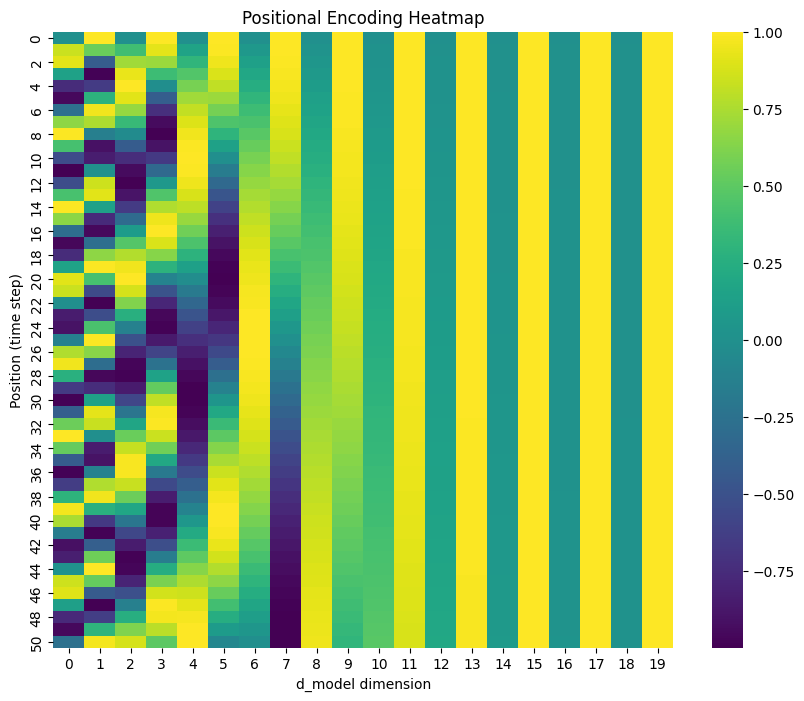

In [5]:
import seaborn as sns

# Instantiate the class with example parameters
d_model = 20  # Dimensionality of the model
T = 50        # Maximum time or sequence length
pos_encoding = MyPositionalEncoding(d_model, T)

# Convert the positional encoding tensor to a NumPy array
pe_matrix = pos_encoding.pe.numpy()

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(pe_matrix, cmap='viridis', cbar=True)
plt.title("Positional Encoding Heatmap")
plt.xlabel("d_model dimension")
plt.ylabel("Position (time step)")
plt.show()

In [143]:
class DiffusionModel():

  def __init__(self, T, model: nn.Module):
    self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
    self.alphas = 1 - self.betas
    self.alphas_bar = torch.cumprod(self.alphas, 0)

    self.T = T
    self.model = model

  def forward_process(self, x0, t):
    """
    :param t: Number of diffusion steps
    """

    t = t - 1 # Because we start indexing at 0

    factors = self.alphas_bar[t].view(*((self.alphas_bar[t].shape[0],) + (1,) * (len(x0.shape) - 1)))
    mu = torch.sqrt(factors) * x0
    std = torch.sqrt(1 - factors)
    epsilon = torch.randn_like(x0)

    return mu + epsilon * std # data ~ N(mu, std)

  def reverse_process(self, xt, t):
    """
    :param t: Number of diffusion steps
    """

    pred_eps = self.model(xt, t)

    return xt - pred_eps

  def sample(self, shape):
    noise = torch.randn(shape)
    x = noise

    for t in range(self.T, 0, -1):

        if not (t == 1):
            x = self.reverse_process(x, torch.tensor([t] * shape[0]))

    return x

In [144]:
class MLP(nn.Module):

    def __init__(self, T, num_layers=2, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        self.linear = nn.Linear(data_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.middlenet = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()) for _ in range(num_layers)
        ])
        self.pos_encoding = MyPositionalEncoding(hidden_dim, T)
        self.output = nn.Linear(hidden_dim, data_dim)

    def forward(self, x, t):

        x = self.linear(x)
        x = x + self.pos_encoding.pe[t]
        x = self.relu(x)
        for layer in self.middlenet:
            x = layer(x)
            x = x + self.pos_encoding.pe[t]
            x = self.relu(x)
        x = self.output(x)

        return x

In [145]:
from tqdm import tqdm
from torch.nn import MSELoss
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset

# Training settings
batch_size = 4
num_epochs = 1000
learning_rate = 0.001
t_emb_dim = 4

dataset = sample_batch(100)

train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T = 50
mlp = MLP(T=T, num_layers=50, data_dim = 2, hidden_dim = 64).to(device)
diff_model = DiffusionModel(T=T, model=mlp)
criterion = MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  diff_model.model.train()
  for i, images in enumerate(tqdm(train_loader)):
    images = images.to(device)
    t = torch.randint(0, T, (images.size(0),)).to(device)
    x_t = diff_model.forward_process(images, t)
    x_recon = diff_model.reverse_process(x_t, t)
    loss = criterion(images, x_recon)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Training complete.")

100%|██████████| 20/20 [00:01<00:00, 10.54it/s]


Epoch [1/100], Step [19/20], Loss: 0.3701


100%|██████████| 20/20 [00:00<00:00, 26.00it/s]


Epoch [2/100], Step [19/20], Loss: 0.9723


100%|██████████| 20/20 [00:01<00:00, 19.89it/s]


Epoch [3/100], Step [19/20], Loss: 0.1720


100%|██████████| 20/20 [00:01<00:00, 16.97it/s]


Epoch [4/100], Step [19/20], Loss: 0.1185


100%|██████████| 20/20 [00:00<00:00, 30.93it/s]


Epoch [5/100], Step [19/20], Loss: 1.5875


100%|██████████| 20/20 [00:00<00:00, 28.53it/s]


Epoch [6/100], Step [19/20], Loss: 1.0616


100%|██████████| 20/20 [00:00<00:00, 43.27it/s]


Epoch [7/100], Step [19/20], Loss: 0.5810


100%|██████████| 20/20 [00:00<00:00, 51.26it/s]


Epoch [8/100], Step [19/20], Loss: 0.0580


100%|██████████| 20/20 [00:00<00:00, 51.29it/s]


Epoch [9/100], Step [19/20], Loss: 0.0183


100%|██████████| 20/20 [00:00<00:00, 55.69it/s]


Epoch [10/100], Step [19/20], Loss: 0.9004


100%|██████████| 20/20 [00:00<00:00, 53.81it/s]


Epoch [11/100], Step [19/20], Loss: 0.4468


100%|██████████| 20/20 [00:00<00:00, 55.65it/s]


Epoch [12/100], Step [19/20], Loss: 1.2576


100%|██████████| 20/20 [00:00<00:00, 54.91it/s]


Epoch [13/100], Step [19/20], Loss: 0.4127


100%|██████████| 20/20 [00:00<00:00, 51.58it/s]


Epoch [14/100], Step [19/20], Loss: 0.0052


100%|██████████| 20/20 [00:00<00:00, 56.66it/s]


Epoch [15/100], Step [19/20], Loss: 0.5938


100%|██████████| 20/20 [00:00<00:00, 56.66it/s]


Epoch [16/100], Step [19/20], Loss: 0.1976


100%|██████████| 20/20 [00:00<00:00, 53.86it/s]


Epoch [17/100], Step [19/20], Loss: 1.3862


100%|██████████| 20/20 [00:00<00:00, 56.02it/s]


Epoch [18/100], Step [19/20], Loss: 0.9554


100%|██████████| 20/20 [00:00<00:00, 58.51it/s]


Epoch [19/100], Step [19/20], Loss: 0.3606


100%|██████████| 20/20 [00:00<00:00, 56.30it/s]


Epoch [20/100], Step [19/20], Loss: 0.3356


100%|██████████| 20/20 [00:00<00:00, 50.73it/s]


Epoch [21/100], Step [19/20], Loss: 0.0317


100%|██████████| 20/20 [00:00<00:00, 40.34it/s]


Epoch [22/100], Step [19/20], Loss: 0.4023


100%|██████████| 20/20 [00:00<00:00, 39.46it/s]


Epoch [23/100], Step [19/20], Loss: 0.2726


100%|██████████| 20/20 [00:00<00:00, 39.17it/s]


Epoch [24/100], Step [19/20], Loss: 0.3169


100%|██████████| 20/20 [00:00<00:00, 40.43it/s]


Epoch [25/100], Step [19/20], Loss: 0.0242


100%|██████████| 20/20 [00:00<00:00, 36.32it/s]


Epoch [26/100], Step [19/20], Loss: 0.3000


100%|██████████| 20/20 [00:00<00:00, 35.97it/s]


Epoch [27/100], Step [19/20], Loss: 0.0249


100%|██████████| 20/20 [00:00<00:00, 33.51it/s]


Epoch [28/100], Step [19/20], Loss: 0.5754


100%|██████████| 20/20 [00:00<00:00, 48.70it/s]


Epoch [29/100], Step [19/20], Loss: 0.1062


100%|██████████| 20/20 [00:00<00:00, 57.22it/s]


Epoch [30/100], Step [19/20], Loss: 0.0305


100%|██████████| 20/20 [00:00<00:00, 56.75it/s]


Epoch [31/100], Step [19/20], Loss: 0.0066


100%|██████████| 20/20 [00:00<00:00, 53.72it/s]


Epoch [32/100], Step [19/20], Loss: 1.0474


100%|██████████| 20/20 [00:00<00:00, 57.47it/s]


Epoch [33/100], Step [19/20], Loss: 0.1278


100%|██████████| 20/20 [00:00<00:00, 57.65it/s]


Epoch [34/100], Step [19/20], Loss: 0.0242


100%|██████████| 20/20 [00:00<00:00, 51.14it/s]


Epoch [35/100], Step [19/20], Loss: 0.1125


100%|██████████| 20/20 [00:00<00:00, 57.37it/s]


Epoch [36/100], Step [19/20], Loss: 0.0262


100%|██████████| 20/20 [00:00<00:00, 54.83it/s]


Epoch [37/100], Step [19/20], Loss: 0.2849


100%|██████████| 20/20 [00:00<00:00, 53.21it/s]


Epoch [38/100], Step [19/20], Loss: 0.3277


100%|██████████| 20/20 [00:00<00:00, 56.73it/s]


Epoch [39/100], Step [19/20], Loss: 0.7761


100%|██████████| 20/20 [00:00<00:00, 48.36it/s]


Epoch [40/100], Step [19/20], Loss: 0.2627


100%|██████████| 20/20 [00:00<00:00, 57.35it/s]


Epoch [41/100], Step [19/20], Loss: 0.2331


100%|██████████| 20/20 [00:00<00:00, 57.73it/s]


Epoch [42/100], Step [19/20], Loss: 0.2296


100%|██████████| 20/20 [00:00<00:00, 50.48it/s]


Epoch [43/100], Step [19/20], Loss: 0.0191


100%|██████████| 20/20 [00:00<00:00, 56.83it/s]


Epoch [44/100], Step [19/20], Loss: 1.2390


100%|██████████| 20/20 [00:00<00:00, 50.20it/s]


Epoch [45/100], Step [19/20], Loss: 0.1806


100%|██████████| 20/20 [00:00<00:00, 55.23it/s]


Epoch [46/100], Step [19/20], Loss: 0.0653


100%|██████████| 20/20 [00:00<00:00, 57.27it/s]


Epoch [47/100], Step [19/20], Loss: 0.1165


100%|██████████| 20/20 [00:00<00:00, 51.11it/s]


Epoch [48/100], Step [19/20], Loss: 0.1497


100%|██████████| 20/20 [00:00<00:00, 55.21it/s]


Epoch [49/100], Step [19/20], Loss: 1.2107


100%|██████████| 20/20 [00:00<00:00, 56.87it/s]


Epoch [50/100], Step [19/20], Loss: 1.2484


100%|██████████| 20/20 [00:00<00:00, 49.18it/s]


Epoch [51/100], Step [19/20], Loss: 0.0393


100%|██████████| 20/20 [00:00<00:00, 57.92it/s]


Epoch [52/100], Step [19/20], Loss: 0.6400


100%|██████████| 20/20 [00:00<00:00, 52.67it/s]


Epoch [53/100], Step [19/20], Loss: 0.5482


100%|██████████| 20/20 [00:00<00:00, 54.97it/s]


Epoch [54/100], Step [19/20], Loss: 0.2419


100%|██████████| 20/20 [00:00<00:00, 49.71it/s]


Epoch [55/100], Step [19/20], Loss: 0.8015


100%|██████████| 20/20 [00:00<00:00, 36.47it/s]


Epoch [56/100], Step [19/20], Loss: 0.4225


100%|██████████| 20/20 [00:00<00:00, 39.95it/s]


Epoch [57/100], Step [19/20], Loss: 0.3237


100%|██████████| 20/20 [00:00<00:00, 38.22it/s]


Epoch [58/100], Step [19/20], Loss: 0.0837


100%|██████████| 20/20 [00:00<00:00, 36.69it/s]


Epoch [59/100], Step [19/20], Loss: 0.8581


100%|██████████| 20/20 [00:00<00:00, 35.31it/s]


Epoch [60/100], Step [19/20], Loss: 0.2884


100%|██████████| 20/20 [00:00<00:00, 35.56it/s]


Epoch [61/100], Step [19/20], Loss: 0.0066


100%|██████████| 20/20 [00:00<00:00, 37.70it/s]


Epoch [62/100], Step [19/20], Loss: 0.1222


100%|██████████| 20/20 [00:00<00:00, 53.02it/s]


Epoch [63/100], Step [19/20], Loss: 1.0611


100%|██████████| 20/20 [00:00<00:00, 55.37it/s]


Epoch [64/100], Step [19/20], Loss: 2.0712


100%|██████████| 20/20 [00:00<00:00, 56.20it/s]


Epoch [65/100], Step [19/20], Loss: 1.7726


100%|██████████| 20/20 [00:00<00:00, 52.21it/s]


Epoch [66/100], Step [19/20], Loss: 0.4817


100%|██████████| 20/20 [00:00<00:00, 54.73it/s]


Epoch [67/100], Step [19/20], Loss: 0.0141


100%|██████████| 20/20 [00:00<00:00, 55.89it/s]


Epoch [68/100], Step [19/20], Loss: 0.4268


100%|██████████| 20/20 [00:00<00:00, 54.83it/s]


Epoch [69/100], Step [19/20], Loss: 2.1791


100%|██████████| 20/20 [00:00<00:00, 50.12it/s]


Epoch [70/100], Step [19/20], Loss: 0.0551


100%|██████████| 20/20 [00:00<00:00, 52.72it/s]


Epoch [71/100], Step [19/20], Loss: 0.5942


100%|██████████| 20/20 [00:00<00:00, 26.56it/s]


Epoch [72/100], Step [19/20], Loss: 0.3104


100%|██████████| 20/20 [00:00<00:00, 26.30it/s]


Epoch [73/100], Step [19/20], Loss: 0.2827


100%|██████████| 20/20 [00:00<00:00, 20.09it/s]


Epoch [74/100], Step [19/20], Loss: 0.2219


100%|██████████| 20/20 [00:01<00:00, 19.64it/s]


Epoch [75/100], Step [19/20], Loss: 0.1082


100%|██████████| 20/20 [00:00<00:00, 20.19it/s]


Epoch [76/100], Step [19/20], Loss: 0.1466


100%|██████████| 20/20 [00:00<00:00, 20.29it/s]


Epoch [77/100], Step [19/20], Loss: 0.5506


100%|██████████| 20/20 [00:00<00:00, 28.38it/s]


Epoch [78/100], Step [19/20], Loss: 0.2524


100%|██████████| 20/20 [00:01<00:00, 16.98it/s]


Epoch [79/100], Step [19/20], Loss: 0.8295


100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


Epoch [80/100], Step [19/20], Loss: 0.1682


100%|██████████| 20/20 [00:01<00:00, 16.55it/s]


Epoch [81/100], Step [19/20], Loss: 0.8698


100%|██████████| 20/20 [00:00<00:00, 24.82it/s]


Epoch [82/100], Step [19/20], Loss: 0.0038


100%|██████████| 20/20 [00:00<00:00, 31.91it/s]


Epoch [83/100], Step [19/20], Loss: 0.0679


100%|██████████| 20/20 [00:00<00:00, 51.55it/s]


Epoch [84/100], Step [19/20], Loss: 0.8656


100%|██████████| 20/20 [00:00<00:00, 54.78it/s]


Epoch [85/100], Step [19/20], Loss: 0.0231


100%|██████████| 20/20 [00:00<00:00, 48.84it/s]


Epoch [86/100], Step [19/20], Loss: 1.5379


100%|██████████| 20/20 [00:00<00:00, 55.56it/s]


Epoch [87/100], Step [19/20], Loss: 0.6654


100%|██████████| 20/20 [00:00<00:00, 26.52it/s]


Epoch [88/100], Step [19/20], Loss: 0.0703


100%|██████████| 20/20 [00:00<00:00, 26.31it/s]


Epoch [89/100], Step [19/20], Loss: 1.4969


100%|██████████| 20/20 [00:00<00:00, 32.51it/s]


Epoch [90/100], Step [19/20], Loss: 0.0563


100%|██████████| 20/20 [00:00<00:00, 53.06it/s]


Epoch [91/100], Step [19/20], Loss: 0.0293


100%|██████████| 20/20 [00:00<00:00, 52.39it/s]


Epoch [92/100], Step [19/20], Loss: 0.1988


100%|██████████| 20/20 [00:00<00:00, 53.37it/s]


Epoch [93/100], Step [19/20], Loss: 0.5254


100%|██████████| 20/20 [00:00<00:00, 44.55it/s]


Epoch [94/100], Step [19/20], Loss: 0.3674


100%|██████████| 20/20 [00:00<00:00, 54.54it/s]


Epoch [95/100], Step [19/20], Loss: 1.4722


100%|██████████| 20/20 [00:00<00:00, 50.39it/s]


Epoch [96/100], Step [19/20], Loss: 0.2828


100%|██████████| 20/20 [00:00<00:00, 52.45it/s]


Epoch [97/100], Step [19/20], Loss: 0.1305


100%|██████████| 20/20 [00:00<00:00, 56.16it/s]


Epoch [98/100], Step [19/20], Loss: 1.8726


100%|██████████| 20/20 [00:00<00:00, 46.82it/s]


Epoch [99/100], Step [19/20], Loss: 1.0667


100%|██████████| 20/20 [00:00<00:00, 54.28it/s]

Epoch [100/100], Step [19/20], Loss: 0.4235
Training complete.


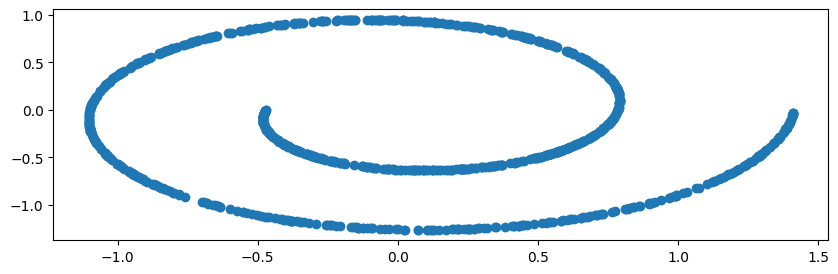

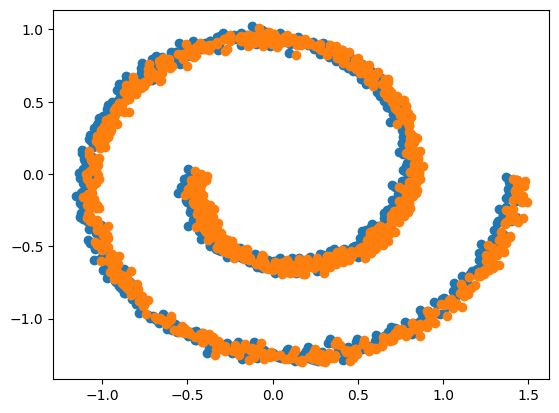

In [149]:
fontsize = 14
fig = plt.figure(figsize=(10, 3))

diff_model.model.eval()
with torch.no_grad():
  dataset = sample_batch(1000)
  t = 20
  t = torch.tensor([t] * dataset.shape[0])
  xt = diff_model.forward_process(dataset, t)
  x_recon = diff_model.reverse_process(xt, t)
  plt.scatter(dataset[:, 0].data.numpy(), dataset[:, 1].data.numpy())
  plt.show()
  plt.scatter(xt[:, 0].data.numpy(), xt[:, 1].data.numpy())
  plt.scatter(x_recon[:, 0].data.numpy(), x_recon[:, 1].data.numpy())

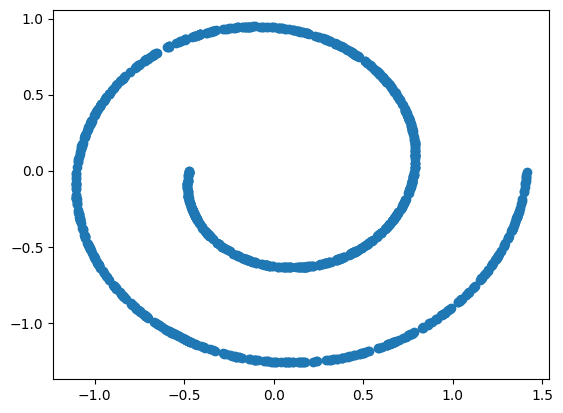

In [120]:
dataset = sample_batch(1000)
plt.scatter(dataset[:, 0].data.numpy(), dataset[:, 1].data.numpy())

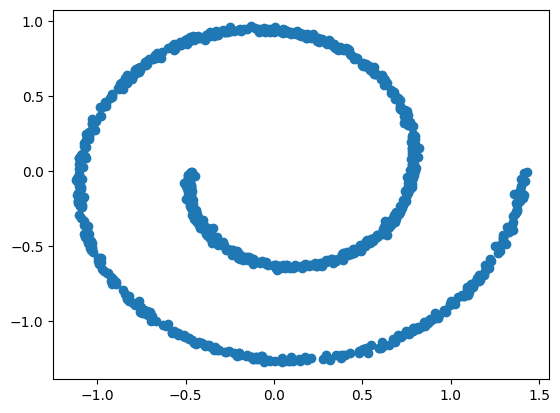

In [99]:
dataset = sample_batch(1000)
t = 8
t = torch.tensor([t] * dataset.shape[0])
xt = diff_model.forward_process(dataset, t)
plt.scatter(xt[:, 0].data.numpy(), xt[:, 1].data.numpy())

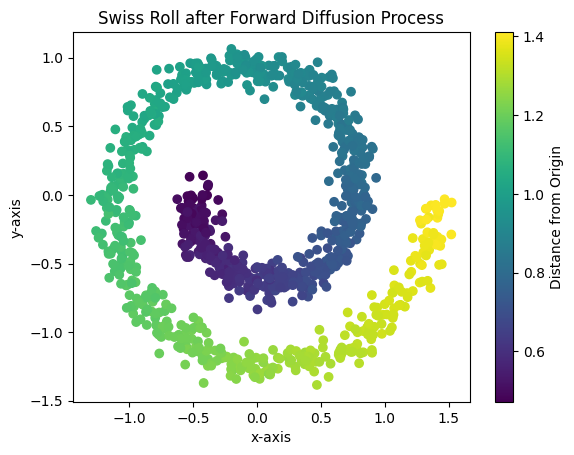

In [148]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming sample_batch and diff_model are defined and working
dataset = sample_batch(1000)
t = 24
t = torch.tensor([t] * dataset.shape[0])
xt = diff_model.forward_process(dataset, t)

# Convert the data to numpy for plotting
xt_np = xt.detach().numpy()
dataset_np = dataset.detach().numpy()

# Calculate the distance from the origin (or any other reference point)
distances = np.sqrt(dataset_np[:, 0]**2 + dataset_np[:, 1]**2)

# Plot the scatter plot with colors based on distance
plt.scatter(xt_np[:, 0], xt_np[:, 1], c=distances, cmap='viridis')
plt.colorbar(label='Distance from Origin')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Swiss Roll after Forward Diffusion Process')
plt.show()